In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick

from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec


In [2]:
url = 'https://docs.google.com/spreadsheets/d/1b3FXkZw8Vi5j9aCXeQElq08aSglCZ7A6AzHz_rPTU5U/edit#gid=1908014063'
data_path = 'dataset2.csv'

cmap = get_cmap('Set2')



In [3]:
df = pd.read_csv(data_path)
# display(df)
# print(df.columns)

grouped_df = df.drop(['number', 'year', 'venue', 'method_repro', 'data_repro', 'experiment_repro'], axis=1)
grouped_df = pd.melt(grouped_df, ['name', 'task'])

grouped_df['value'] = grouped_df['value'].fillna('N/A')
grouped_df['repro'] = grouped_df['variable']
grouped_df['repro'] = grouped_df['repro'].replace(to_replace=r'^data_.*$', value='data', regex=True)
grouped_df['repro'] = grouped_df['repro'].replace(to_replace=r'^method_.*$', value='method', regex=True)
grouped_df['repro'] = grouped_df['repro'].replace(to_replace=r'^experiment_.*$', value='experiment', regex=True)


grouped_df = grouped_df.groupby(['task', 'variable', 'repro', 'value'])['name'].aggregate('count').unstack().reset_index()

# display(df)

grouped_by_year = df.groupby(['year', 'task'])['name'].aggregate('count').unstack().fillna(0).reset_index()
grouped_by_venue = df.groupby(['venue', 'task'])['name'].aggregate('count').unstack().fillna(0).reset_index()
# display(grouped_by_year_repro)


repro_per_year = df[['year', 'method_repro', 'data_repro','experiment_repro']]
repro_per_year = pd.melt(repro_per_year, ['year'], var_name='repro')
repro_per_year = repro_per_year.pivot_table(index = ['repro',
                        repro_per_year.groupby(['repro','year']).cumcount()],
               columns = 'year',
               values = 'value').reset_index()


repro_per_venue = df[['venue', 'method_repro', 'data_repro','experiment_repro']]
repro_per_venue = pd.melt(repro_per_venue, ['venue'], var_name='repro')
repro_per_venue = repro_per_venue.pivot_table(index = ['repro',
                        repro_per_venue.groupby(['repro','venue']).cumcount()],
               columns = 'venue',
               values = 'value').reset_index().drop(['level_1'], axis=1)



In [4]:
data_df = df[['name', 'data_experiment', 'data_ground_truth', 'data_params', 'data_version']]

experiment_df = df[['name', 'experiment_source_code', 'experiment_ref_source_code',
       'experiment_external_source_code', 'experiment_exp_source_code',
       'experiment_setup', 'experiment_hw', 'experiment_sw',
       'experiment_results', 'experiment_runtime']]

method_df = df[['name', 'method_problem',
       'method_objective', 'method_contribution', 'method_workflow',
       'method_research', 'method_pseudo_code', 'method_params',
       'method_params_description']]

def make_countplot(df, axis):
    df = pd.melt(df, ['name'])
    df['value'] = df['value'].fillna('N/A')

    sns.countplot(x='variable', hue='value', data=df, ax=axis)

    labels = [from_snake_to_acronym(l.get_text())[1:] for l in axis.get_xticklabels()]
    axis.set_xticklabels(labels)
    
    
def from_snake_to_acronym(word):
    split_word = word.split('_')
    acronym = ''
    
    for group in split_word:
        acronym = '{}{}'.format(acronym, group[0])
        
    return acronym.upper()

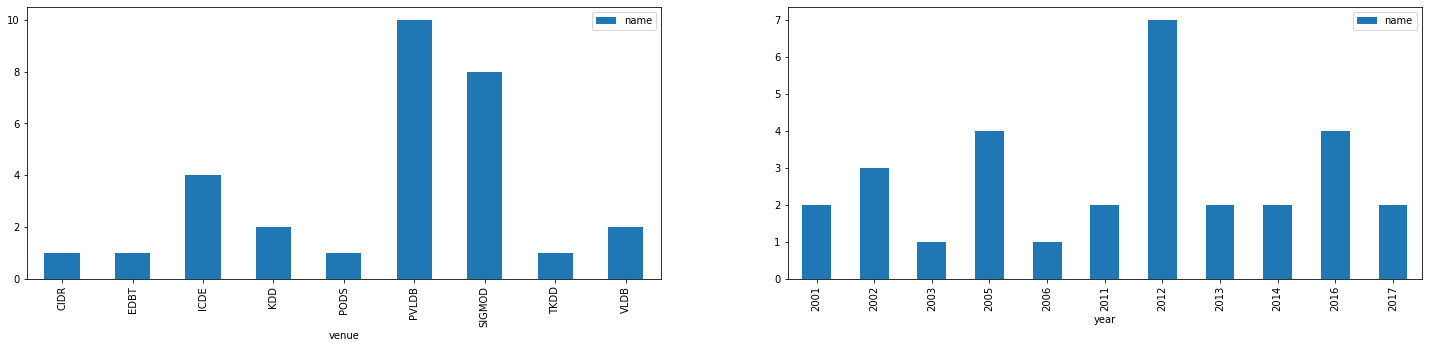

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))

df.groupby(['year']).aggregate('count')['name'].reset_index().plot(x='year', kind='bar', ax=axs[1])
df.groupby(['venue']).aggregate('count')['name'].reset_index().plot(x='venue', kind='bar', ax=axs[0])



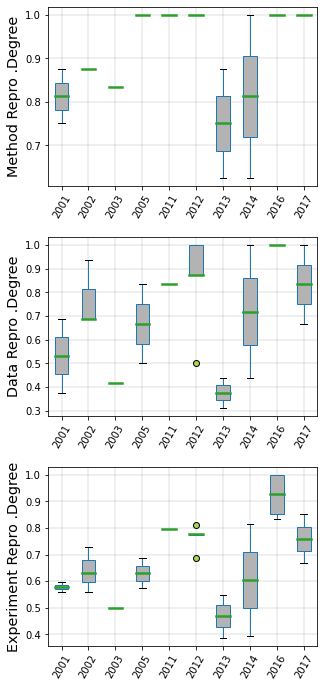

In [24]:
data_repro = repro_per_year[repro_per_year['repro'] == 'data_repro']
method_repro = repro_per_year[repro_per_year['repro'] == 'method_repro']
experiment_repro = repro_per_year[repro_per_year['repro'] == 'experiment_repro']

# display(repro_per_year)
fig, axs = plt.subplots(3, 1, figsize=(5, 10))
fig.tight_layout(pad=3.0)

flierprops = dict(marker='o', markerfacecolor=cmap(4), linestyle='none')
medianprops = dict(linestyle='-', linewidth=2.5, color=cmap(1))

def make_boxplot(axis, cmap, flierprops, medianprops, data, repro_type):
    bplot = data.boxplot(column=[2001,2002,2003,2005,2011,2012,2013,2014,2016,2017],
                                patch_artist=True, return_type='dict', flierprops=flierprops,
                                medianprops=medianprops, ax=axis)

    axis.grid(color='grey', linestyle='-', linewidth=0.25)
    axis.set_ylabel('{} Repro .Degree'.format(repro_type), fontsize='x-large')
    axis.set_xticklabels(axis.get_xticklabels(), rotation='60')
    axis.set_axisbelow(True)

    # fill with colors
    for patch in bplot['boxes']:
        patch.set_facecolor(cmap(7))
            
make_boxplot(axs[0], cmap, flierprops, medianprops, method_repro, 'Method')
make_boxplot(axs[1], cmap, flierprops, medianprops, data_repro, 'Data')
make_boxplot(axs[2], cmap, flierprops, medianprops, experiment_repro, 'Experiment')

plt.savefig('plots/repro-boxplot.pdf', dpi=300, bbox_inches='tight')

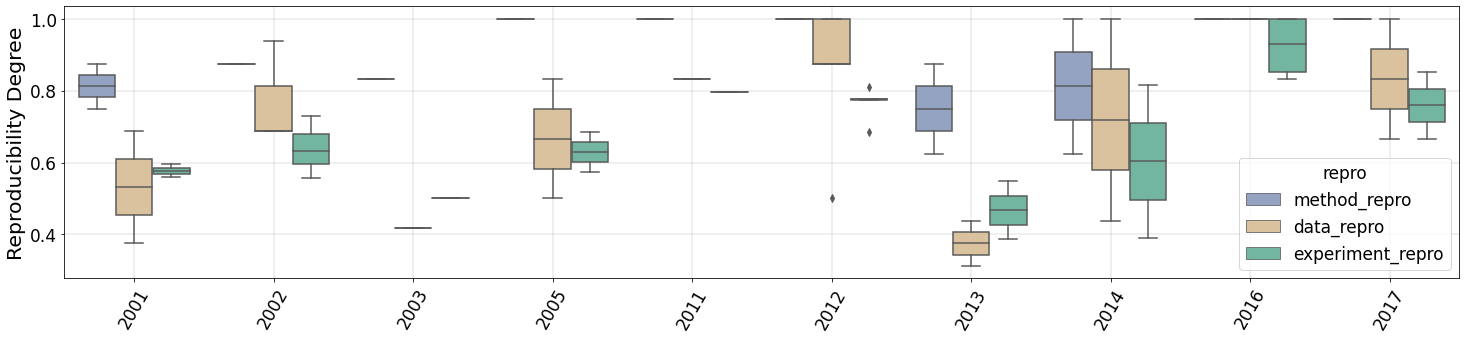

In [5]:
rr = repro_per_year.drop(['level_1'], axis=1)
rr = pd.melt(rr, ['repro'], var_name='year')

plt.figure(figsize=(25, 5))
plt.rcParams.update({'font.size': 17})

axis = sns.boxplot(x='year', y='value', data=rr, hue='repro', palette=[cmap(2), cmap(6), cmap(0)], 
                   hue_order=['method_repro', 'data_repro', 'experiment_repro'])

axis.grid(color='grey', linestyle='-', linewidth=0.25)
axis.set_xlabel('')
axis.set_ylabel('Reproducibility Degree', fontsize='large')
axis.set_xticklabels(axis.get_xticklabels(), rotation='60')
axis.set_axisbelow(True)

plt.savefig('plots/repro-boxplot.pdf', dpi=300, bbox_inches='tight')

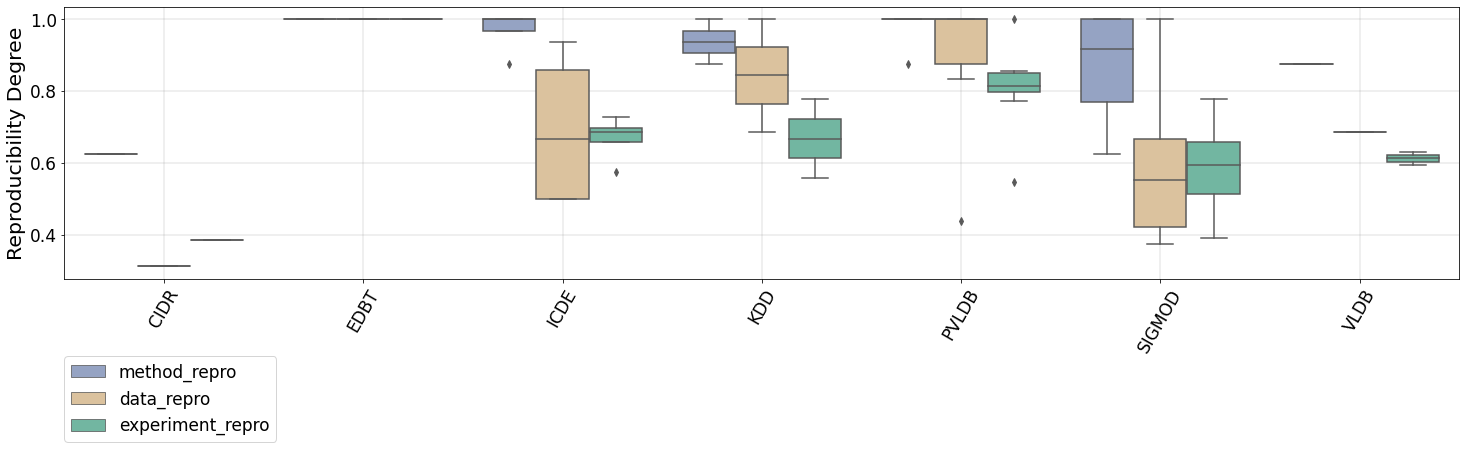

In [6]:
rv = pd.melt(repro_per_venue, ['repro'], var_name='venue')

plt.figure(figsize=(25, 5))
plt.rcParams.update({'font.size': 17})

axis = sns.boxplot(x='venue', y='value', data=rv, hue='repro', palette=[cmap(2), cmap(6), cmap(0)], 
                   hue_order=['method_repro', 'data_repro', 'experiment_repro'])

axis.grid(color='grey', linestyle='-', linewidth=0.25)
axis.set_xlabel('')
axis.set_ylabel('Reproducibility Degree', fontsize='large')
axis.set_xticklabels(axis.get_xticklabels(), rotation='60')
axis.set_axisbelow(True)

h, l = axis.get_legend_handles_labels()
axis.legend(h, l, loc=(0, -0.6), fontsize='medium')
plt.savefig('plots/repro-boxplot-venue.pdf', dpi=300, bbox_inches='tight')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


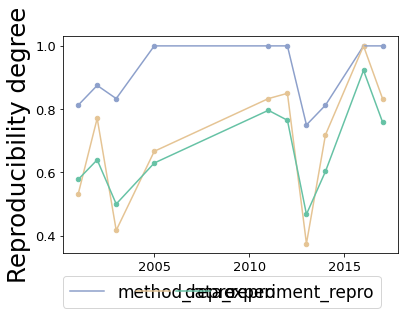

In [7]:
scatter_repro = df[['year', 'method_repro', 'data_repro',
                    'experiment_repro']].groupby('year').aggregate('mean').dropna().reset_index()
# display(scatter_repro)

ax1 = scatter_repro.plot.scatter(x='year', y='method_repro',  c=cmap(2))
scatter_repro.plot.line(x='year', y='method_repro', ax=ax1, color=[cmap(2)])

scatter_repro.plot(x='year', y='data_repro', kind='scatter', ax=ax1, c=cmap(6))
scatter_repro.plot(x='year', y='data_repro', ax=ax1, color=[cmap(6)], fontsize=13)

scatter_repro.plot.scatter(x='year', y='experiment_repro', ax=ax1, c=cmap(0))
scatter_repro.plot.line(x='year', y='experiment_repro', ax=ax1, color=[cmap(0)])

ax1.set_xlabel('')
ax1.set_ylabel('Reproducibility degree', size='x-large')

h, l = ax1.get_legend_handles_labels()
ax1.legend(h, l, loc=(0, -0.25), ncol=3, fontsize='medium', mode='expand')

plt.savefig('plots/repro-scatterplot.pdf', dpi=300, bbox_inches='tight')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


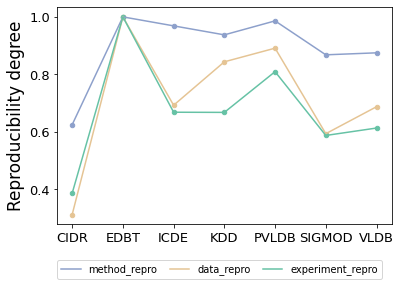

In [8]:
scatter_repro_venue = df[['venue', 'method_repro', 'data_repro',
                    'experiment_repro']].groupby('venue').aggregate('mean').dropna().reset_index()
# display(scatter_repro)

ax1 = scatter_repro_venue.plot.scatter(x='venue', y='method_repro',  c=cmap(2))
scatter_repro_venue.plot.line(x='venue', y='method_repro', ax=ax1, color=[cmap(2)])

scatter_repro_venue.plot(x='venue', y='data_repro', kind='scatter', ax=ax1, c=cmap(6))
scatter_repro_venue.plot(x='venue', y='data_repro', ax=ax1, color=[cmap(6)], fontsize=13)

scatter_repro_venue.plot.scatter(x='venue', y='experiment_repro', ax=ax1, c=cmap(0))
scatter_repro_venue.plot.line(x='venue', y='experiment_repro', ax=ax1, color=[cmap(0)])

ax1.set_xlabel('')
ax1.set_ylabel('Reproducibility degree', size='medium')

h, l = ax1.get_legend_handles_labels()
ax1.legend(h, l, loc=(0, -0.25), ncol=3, fontsize='xx-small', mode='expand')

plt.savefig('plots/repro-scatterplot-venue.pdf', dpi=300, bbox_inches='tight')

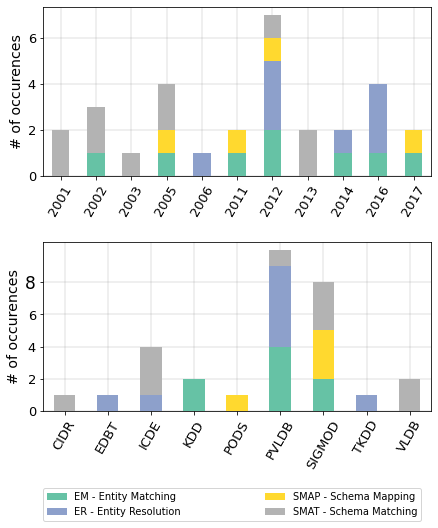

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7))
fig.tight_layout(pad=2.0)

axis1 = grouped_by_year.plot(x='year', kind='bar', stacked=True, ax=axs[0], fontsize=13, colormap=cmap)
axis1.grid(color='grey', linestyle='-', linewidth=0.25)
axis1.set_xlabel('')
axis1.set_ylabel('# of occurences', fontsize='small')
axis1.set_xticklabels(axis1.get_xticklabels(), rotation='60')
axis1.set_axisbelow(True)
axis1.get_legend().remove()


axis2 = grouped_by_venue.plot(x='venue', kind='bar', stacked=True, ax=axs[1], fontsize=13, colormap=cmap)
axis2.grid(color='grey', linestyle='-', linewidth=0.25)
axis2.set_xlabel('')
axis2.set_ylabel('# of occurences', fontsize='small')
axis2.set_xticklabels(axis2.get_xticklabels(), rotation='60')
axis2.set_yticks(range(0, 10, 2))
axis2.set_axisbelow(True)

h, l = axis2.get_legend_handles_labels()
labels = ['EM - Entity Matching', 'ER - Entity Resolution', 'SMAP - Schema Mapping', 'SMAT - Schema Matching']
axis2.legend(h, labels, loc=(0, -0.65), ncol=2, fontsize='xx-small', mode='expand')


plt.savefig('plots/distribution-venue-year.pdf', dpi=300, bbox_inches = "tight")


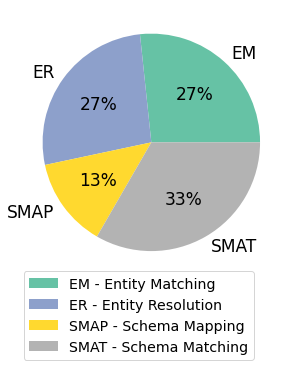

In [32]:
plt.figure(figsize=(25, 5))

axis = df.groupby('task')['name'].aggregate('count').plot.pie(autopct='%1.0f%%', colormap=cmap)

axis.set_ylabel('')

h, l = axis.get_legend_handles_labels()
labels = ['EM - Entity Matching', 'ER - Entity Resolution', 'SMAP - Schema Mapping', 'SMAT - Schema Matching']

axis.legend(h, labels, loc=(0.03, -0.3), ncol=1, fontsize='small')

plt.savefig('plots/distribution-papers.pdf', dpi=300, bbox_inches = "tight")



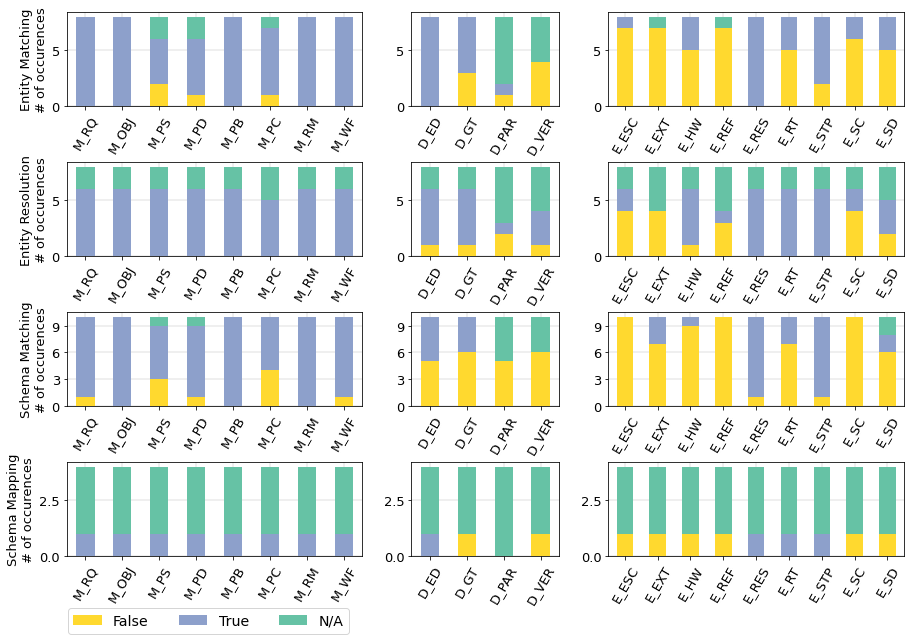

In [33]:
em = grouped_df[grouped_df['task'] == 'EM'].drop(['task'], axis=1)
er = grouped_df[grouped_df['task'] == 'ER'].drop(['task'], axis=1)
smap = grouped_df[grouped_df['task'] == 'SMAP'].drop(['task'], axis=1)
smat = grouped_df[grouped_df['task'] == 'SMAT'].drop(['task'], axis=1)

# display(em)

fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(wspace=0.2, hspace=0.6)

spec = GridSpec(ncols=3, nrows=4, width_ratios=[2, 1, 2], height_ratios=[2, 2, 2, 2])

axs = list()
for i in range(0, 12, 3):
    ax = list()
    for j in range(i, i + 3):
        ax.append(fig.add_subplot(spec[j]))
    axs.append(ax)

xticklabels = {
    'data_experiment': 'D_ED',
    'data_ground_truth': 'D_GT',
    'data_params': 'D_PAR',
    'data_version': 'D_VER',
    'experiment_exp_source_code': 'E_ESC',
    'experiment_external_source_code': 'E_EXT',
    'experiment_hw': 'E_HW',
    'experiment_ref_source_code': 'E_REF', 
    'experiment_results': 'E_RES',
    'experiment_runtime': 'E_RT', 
    'experiment_setup': 'E_STP',
    'experiment_source_code': 'E_SC',
    'experiment_sw': 'E_SD', 
    'method_contribution': 'M_RQ',
    'method_objective': 'M_OBJ',
    'method_params': 'M_PS', 
    'method_params_description': 'M_PD', 
    'method_problem': 'M_PB',
    'method_pseudo_code': 'M_PC', 
    'method_research': 'M_RM', 
    'method_workflow': 'M_WF'   
}

def barplot_per_repro(data, axis, task):
    fontsize = 13
    xlabel_font = 13
    
    ddf = data[data['repro'] == 'data'].drop(['repro'], axis=1)
    mdf = data[data['repro'] == 'method'].drop(['repro'], axis=1)
    edf = data[data['repro'] == 'experiment'].drop(['repro'], axis=1)
    
    mdf.plot(x='variable', kind='bar', ax=axis[0], stacked=True, fontsize=fontsize,
             color=[cmap(5), cmap(2), cmap(0)])
    ddf.plot(x='variable', kind='bar', ax=axis[1], stacked=True, fontsize=fontsize, 
             color=[cmap(5), cmap(2), cmap(0)])
    edf.plot(x='variable', kind='bar', ax=axis[2], stacked=True, fontsize=fontsize,
             color=[cmap(5), cmap(2), cmap(0)])
    
    for ax in axis:
        ax.grid(color='grey', linestyle='-', linewidth=0.25)
        ax.set_xlabel('')
        ax.set_ylabel('{}\n# of occurences'.format(task), fontsize=xlabel_font)
        ax.set_xticklabels(list(map(lambda x: xticklabels[x.get_text()], ax.get_xticklabels())), rotation='60')
        ax.set_axisbelow(True)
        ax.get_legend().remove()
        
    for ax in axis[1:]:
        ax.set_ylabel('')
        
    if task == 'Schema Matching':
        [ax.set_yticks(range(0, 10, 3)) for ax in axis]
        
    

barplot_per_repro(em, axs[0], 'Entity Matching')
barplot_per_repro(er, axs[1], 'Entity Resolution')
barplot_per_repro(smat, axs[2], 'Schema Matching')
barplot_per_repro(smap, axs[3], 'Schema Mapping')

lgd = plt.legend(loc=(-1.83, -0.83), ncol=3, fontsize='small', mode='expand')
plt.savefig('plots/distribution-task-variable.pdf', dpi=300, 
            bbox_extra_artists=(lgd,), bbox_inches='tight')


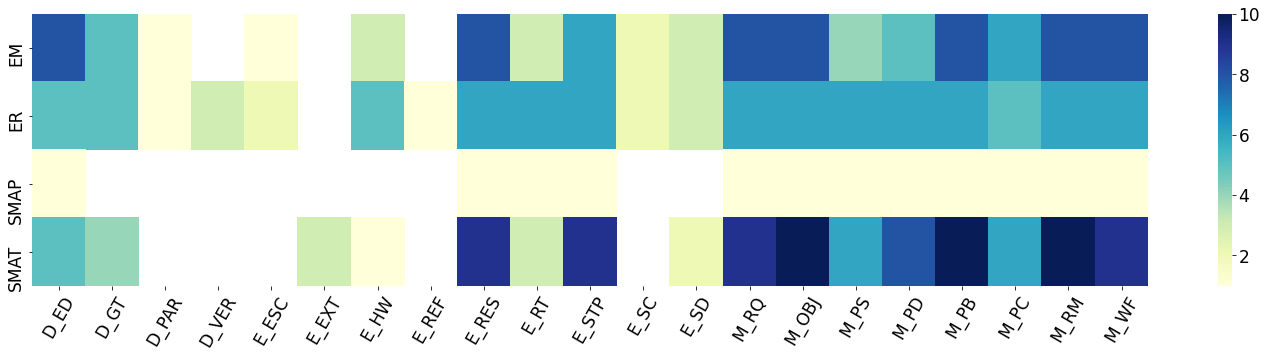

In [34]:
# fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
plt.figure(figsize=(25, 5))

truedf = grouped_df.drop(['repro', False, 'N/A'], axis=1).pivot('task', 'variable', True)
# falsedf = grouped_df.drop(['repro', True, 'N/A'], axis=1).pivot('task', 'variable', False)
# nadf = grouped_df.drop(['repro', False, True], axis=1).pivot('task', 'variable', 'N/A')

ax = sns.heatmap(truedf, cmap="YlGnBu")
# sns.heatmap(falsedf, ax=axs[1])
# sns.heatmap(nadf, ax=axs[2])

# for ax in axs:
ax.set_xlabel('')
ax.set_ylabel('')
ticks = ax.set_xticklabels(list(map(lambda x: xticklabels[x.get_text()], ax.get_xticklabels())), rotation='60')

plt.savefig('plots/heatmap-true-variables.pdf', dpi=300, bbox_inches='tight')